In [79]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import numpy as np
import matplotlib.pyplot as plt
from os.path import join
import os
from tqdm import tqdm

# Read in Citibike stations.

We will use this shapefile to lookup neighborhood codes by station id.

In [80]:
root = ".."
inputfile = join(root, "data", "citibike_stations", "spatial_join.shp")
stations = gpd.read_file(inputfile)

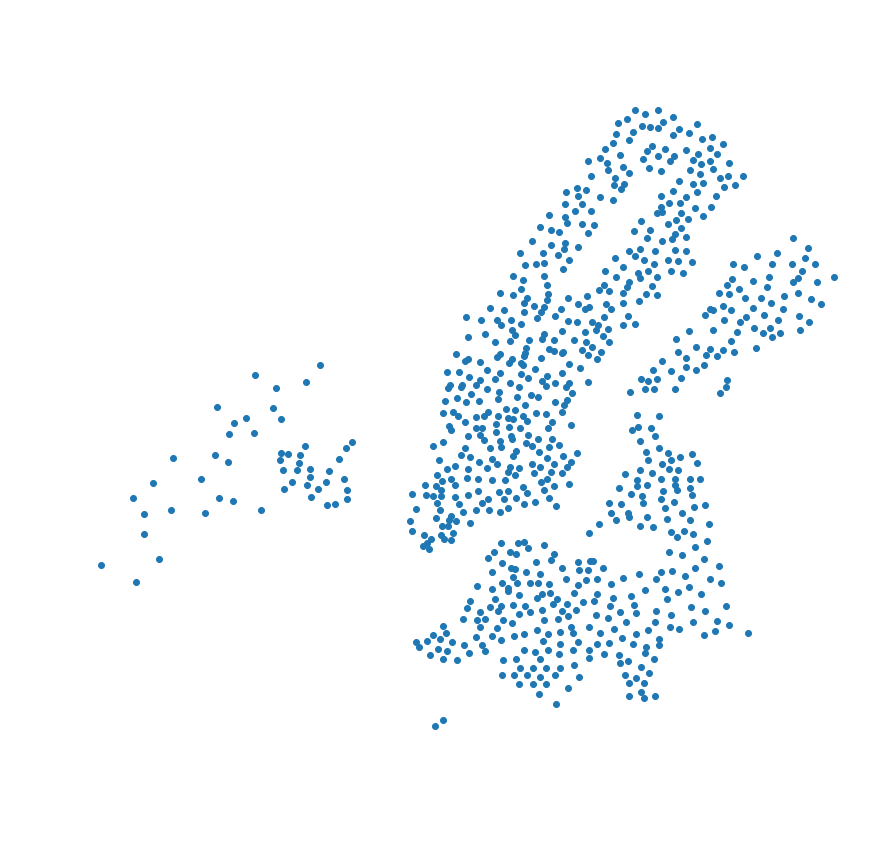

Citibike Stations


In [81]:
f, ax = plt.subplots(1, figsize=(15,15))
stations.plot(ax=ax, )
ax.set_axis_off()
plt.axis('equal')
plt.show()
print("Citibike Stations")

In [82]:
stations.head()

,id,name,test,docks,index_righ,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,72,W 52 St & 11 Ave,0,39,70,1,Manhattan,061,MN15,Clinton,35037.171670,1.838139e+07,POINT (-73.99392888 40.76727216)
1,79,Franklin St & W Broadway,0,33,101,1,Manhattan,061,MN24,SoHo-TriBeCa-Civic Center-Little Italy,26854.636018,2.503262e+07,POINT (-74.00666661 40.71911552)
2,82,St James Pl & Pearl St,0,27,114,1,Manhattan,061,MN27,Chinatown,20786.256014,1.450187e+07,POINT (-74.00016545 40.71117416)
3,83,Atlantic Ave & Fort Greene Pl,0,62,47,3,Brooklyn,047,BK68,Fort Greene,19825.520886,1.648282e+07,POINT (-73.97632328 40.68382604)
4,119,Park Ave & St Edwards St,0,19,47,3,Brooklyn,047,BK68,Fort Greene,19825.520886,1.648282e+07,POINT (-73.97803415 40.69608941)


# Read in Neighborhoods

In [83]:
inputfile = join(root, "data", "neighborhood_tabulation_areas", "nyc_and_jc_neighborhoods",
                 "nyc_and_jc_neighborhoods.shp")
neighborhoods = gpd.read_file(inputfile)

In [84]:
neighborhoods.head()

,BoroCode,BoroName,CountyFIPS,NTACode,NTAName,Shape_Leng,Shape_Area,geometry
0,3,Brooklyn,047,BK88,Borough Park,39247.228028,5.400502e+07,POLYGON ((-73.97604935657381 40.63127590564677...
1,4,Queens,081,QN52,East Flushing,25843.364936,2.945438e+07,POLYGON ((-73.79493246233996 40.75779803007455...
2,4,Queens,081,QN48,Auburndale,32446.878673,3.416422e+07,POLYGON ((-73.77573836927098 40.74332564716399...
3,4,Queens,081,QN51,Murray Hill,33266.904811,5.248828e+07,POLYGON ((-73.80379022888246 40.77561011179249...
4,4,Queens,081,QN27,East Elmhurst,19816.712323,1.972685e+07,"POLYGON ((-73.86109724335759 40.7636644770869,..."


# Create master departures dataframe

In [85]:
citibike_trips_path = join(root,"data","citibike_trips")

In [86]:
departures = []

for i in tqdm(os.listdir(citibike_trips_path)):
    
    df = pd.read_csv(join(citibike_trips_path, i))
    df = pd.merge(df, stations[['id', 'BoroName','NTACode', 'NTAName']],
                     how='left', left_on='start_station_id', right_on='id')
    departure_df = df[['starttime', 'start_station_id', 'start_station_latitude',
                  'start_station_longitude', 'BoroName','NTACode', 'NTAName']]
    departures.append(departure_df)

100%|██████████| 54/54 [03:07<00:00,  3.48s/it]


In [87]:
%%time
departures = pd.concat(departures)

CPU times: user 2.82 s, sys: 4.13 s, total: 6.95 s
Wall time: 7.31 s


In [88]:
%%time
departures['starttime'] = pd.to_datetime(departures['starttime'])

CPU times: user 24min 40s, sys: 7.27 s, total: 24min 47s
Wall time: 24min 52s


In [89]:
departures.shape

(35116629, 7)

In [90]:
departures.shape

(35116629, 7)

# Georeference the remaining missing values

In [91]:
departures_with_nans = departures[departures['NTACode'].astype(str) == "nan"].copy()

# Add spatial reference to dataframe
geometry = [Point(xy) for xy in zip(departures_with_nans.start_station_longitude, departures_with_nans.start_station_latitude)]
crs = {'init': 'epsg:4326'}
departures_with_nans = gpd.GeoDataFrame(departures_with_nans, crs=crs, geometry=geometry)

In [92]:
departures_with_nans = gpd.sjoin(departures_with_nans, neighborhoods, how="left", op='within')

In [93]:
del departures_with_nans['BoroName_left']
del departures_with_nans['NTACode_left']
del departures_with_nans['NTAName_left']
del departures_with_nans['index_right']
del departures_with_nans['Shape_Leng']
del departures_with_nans['Shape_Area']
del departures_with_nans['geometry']
del departures_with_nans['BoroCode']
del departures_with_nans['CountyFIPS']

In [94]:
departures_with_nans.rename(columns={'BoroName_right': 'BoroName', 'NTACode_right': 'NTACode', 
                                     'NTAName_right': 'NTAName'},
                            inplace=True)

In [95]:
# drop nans from main dataframe
departures = departures.dropna(subset=['NTACode'])

In [96]:
# add the spatially joined nan's back in
departures = pd.concat([departures, departures_with_nans])

In [113]:
departures.head()

,starttime,start_station_id,start_station_latitude,start_station_longitude,BoroName,NTACode,NTAName,year,month,yearMonth
0,2016-01-01 00:02:52,3186,40.719586,-74.043117,Jersey City,JC,Jersey City,2016,01,201601
1,2016-01-01 00:18:22,3186,40.719586,-74.043117,Jersey City,JC,Jersey City,2016,01,201601
2,2016-01-01 00:18:25,3186,40.719586,-74.043117,Jersey City,JC,Jersey City,2016,01,201601
3,2016-01-01 00:23:13,3209,40.724176,-74.050656,Jersey City,JC,Jersey City,2016,01,201601
4,2016-01-01 01:03:20,3195,40.730743,-74.063784,Jersey City,JC,Jersey City,2016,01,201601


In [98]:
departures.shape

(35116629, 7)

In [111]:
%%time
output_dir = join(root, "data", "citibike_departures")
output_filename = "citibike_departures.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

CPU times: user 99 µs, sys: 335 µs, total: 434 µs
Wall time: 293 µs


In [114]:
departures.to_csv(join(output_dir, output_filename))

# Total 2016 - 2018 Departures by Neighborood

In [115]:
departures_by_neighborhood = departures.groupby(by='NTAName').count()
departures_by_neighborhood['count'] = departures_by_neighborhood['NTACode']
departures_by_neighborhood = departures_by_neighborhood[['count']]
departures_by_neighborhood.sort_values('count', ascending=False)

,count
NTAName,
Hudson Yards-Chelsea-Flatiron-Union Square,4337000
Midtown-Midtown South,3265285
West Village,3133320
SoHo-TriBeCa-Civic Center-Little Italy,2487252
Murray Hill-Kips Bay,1970999
Battery Park City-Lower Manhattan,1780389
East Village,1536867
Clinton,1333070
Chinatown,1168210


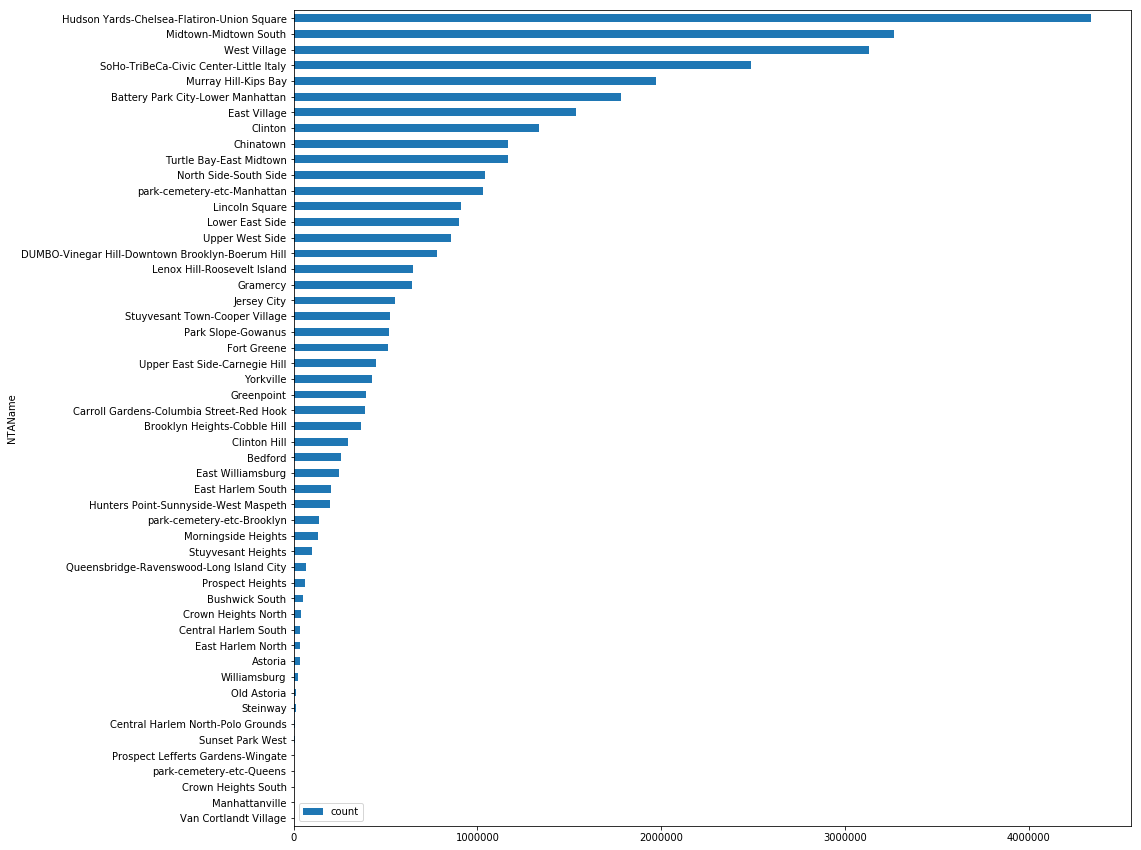

In [116]:
f, ax = plt.subplots(1, figsize=(15,15))
departures_by_neighborhood.sort_values('count').plot(ax=ax, kind='barh')
#ax.set_axis_off()
plt.show()

In [117]:
neighborhoods.index = neighborhoods['NTAName']

/anaconda/envs/py36/lib/python3.6/site-packages/matplotlib/colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


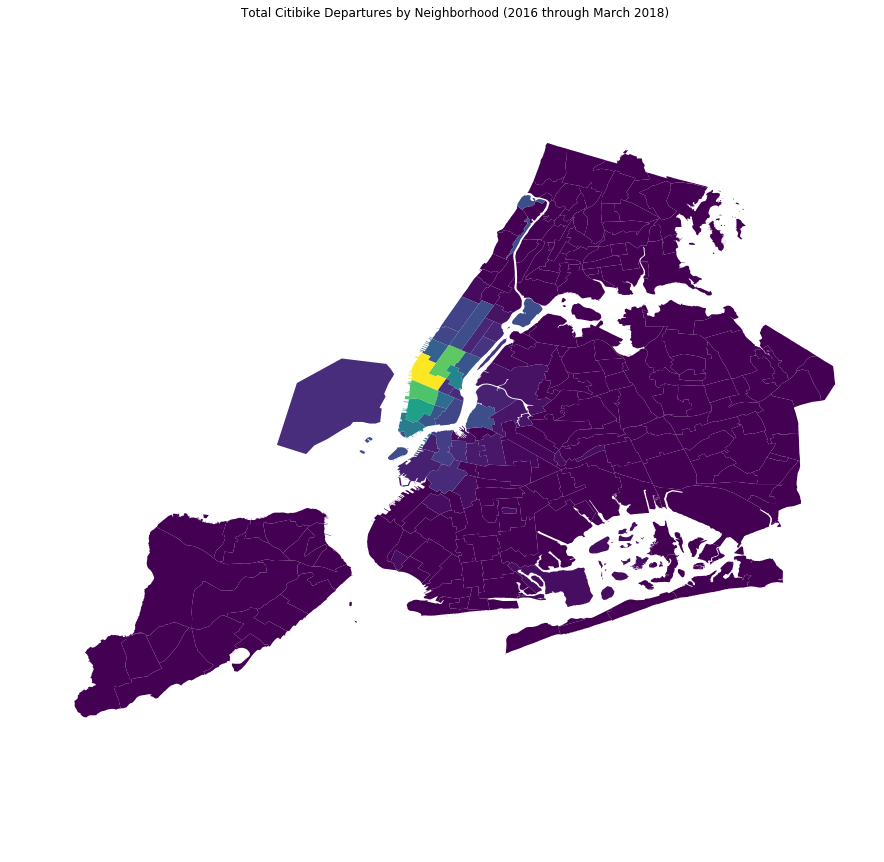

In [118]:
f, ax = plt.subplots(1, figsize=(15,15))
neighborhoods.join(departures_by_neighborhood, how='left').plot(column='count', ax=ax)
ax.set_axis_off()
plt.axis('equal')
plt.title("Total Citibike Departures by Neighborhood (2016 through March 2018)")
plt.show()

# 2016 - 2018 Total Citibike Monthly Departures over Time

In [119]:
departures_monthly = departures.resample('M', on='starttime').count()
departures_monthly['count'] = departures_monthly['NTAName']
departures_monthly = departures_monthly[['count']]

In [120]:
departures_monthly.head()

,count
starttime,
2016-01-31,516956
2016-02-29,569118
2016-03-31,933413
2016-04-30,1029468
2016-05-31,1231748


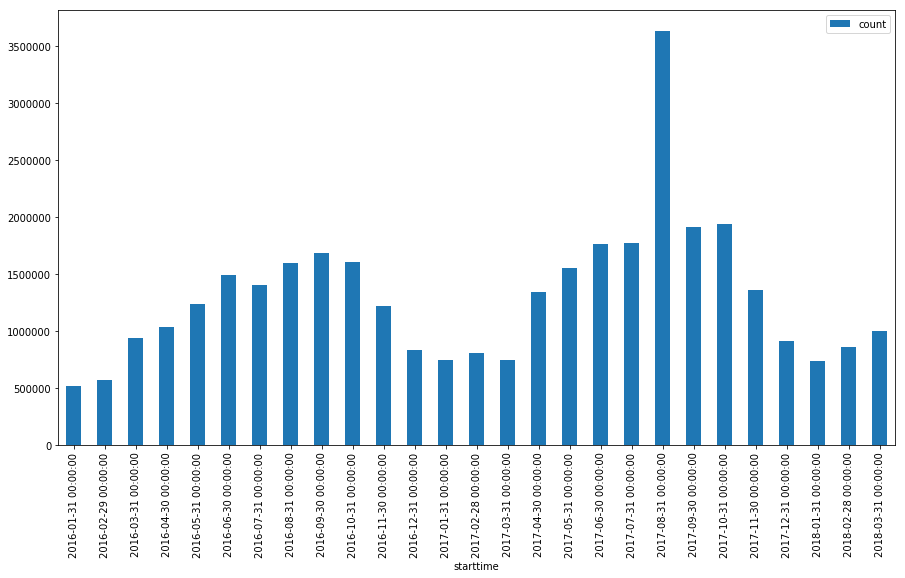

In [121]:
f, ax = plt.subplots(1, figsize=(15,8))
departures_monthly.plot(ax=ax, kind='bar')
#ax.set_axis_off()
plt.show()

# 2016 - 2018 Monthly Departures by Neighborhood

In [122]:
departures['year'] = departures['starttime'].dt.year
departures['year'] = departures['year'].astype(str)

departures['month'] = departures['starttime'].dt.month
departures['month'] = departures['month'].astype(str)
departures['month'] = departures['month'].str.zfill(2)

departures['yearMonth'] = departures['year'] + departures['month']

In [123]:
departures.head()

,starttime,start_station_id,start_station_latitude,start_station_longitude,BoroName,NTACode,NTAName,year,month,yearMonth
0,2016-01-01 00:02:52,3186,40.719586,-74.043117,Jersey City,JC,Jersey City,2016,01,201601
1,2016-01-01 00:18:22,3186,40.719586,-74.043117,Jersey City,JC,Jersey City,2016,01,201601
2,2016-01-01 00:18:25,3186,40.719586,-74.043117,Jersey City,JC,Jersey City,2016,01,201601
3,2016-01-01 00:23:13,3209,40.724176,-74.050656,Jersey City,JC,Jersey City,2016,01,201601
4,2016-01-01 01:03:20,3195,40.730743,-74.063784,Jersey City,JC,Jersey City,2016,01,201601


In [124]:
departures.shape

(35116629, 10)

In [129]:
%%time
departures_monthly_by_neighborhood = departures.groupby(by=['NTACode', 'yearMonth']).count()
departures_monthly_by_neighborhood['citibike_departures'] = departures_monthly_by_neighborhood['starttime']
departures_monthly_by_neighborhood = departures_monthly_by_neighborhood[['citibike_departures']]
departures_monthly_by_neighborhood = pd.DataFrame.from_records(departures_monthly_by_neighborhood.to_records())

CPU times: user 12.4 s, sys: 18.8 s, total: 31.2 s
Wall time: 37.9 s


In [130]:
departures_monthly_by_neighborhood.head()

,NTACode,yearMonth,citibike_departures
0,BK09,201601,4310
1,BK09,201602,4963
2,BK09,201603,7599
3,BK09,201604,9172
4,BK09,201605,11370


In [131]:
%%time
output_dir = join(root, "data", "citibike_departures")
output_filename = "citibike_departures_monthly_by_neighborhood.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

departures_monthly_by_neighborhood.to_csv(join(output_dir, output_filename))

CPU times: user 4.03 ms, sys: 3.72 ms, total: 7.76 ms
Wall time: 7.8 ms


In [132]:
%%time
output_dir = join(root, "data", "_model_inputs")
output_filename = "citibike_departures_monthly_by_neighborhood.csv"
# Make data directory
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

departures_monthly_by_neighborhood.to_csv(join(output_dir, output_filename))

CPU times: user 4.38 ms, sys: 2.45 ms, total: 6.83 ms
Wall time: 5.34 ms


# Below is only necessary if we decide to build LSTM for hourly forecasts

# Count hourly departures (with time lags) by neighborhood

In [119]:
departures = departures.dropna(subset=['BoroName', 'NTACode', 'NTAName'])

In [207]:
unique_origin_neighborhoods_in_departures = list(np.unique(departures['NTACode'].values))

In [214]:
departures_by_neighborhood_lagged = []

num_lagging_periods = 24 * 7

for n in tqdm(unique_origin_neighborhoods_in_departures):
    subset = departures[departures['NTACode'] == n].copy()
    subset_hourly = subset.resample('H', on='starttime').count()[['starttime']].reindex(hour_range).fillna(0)
    subset_hourly.columns = [n]
    for i in range(1, num_lagging_periods+1):
        column_name = '{}_t-{}'.format(n, i)
        subset_hourly[column_name] = subset_hourly[n].shift(i)
    departures_by_neighborhood_lagged.append(subset_hourly)

100%|██████████| 52/52 [01:20<00:00,  1.56s/it]


In [215]:
departures_by_neighborhood_lagged = pd.concat(departures_by_neighborhood_lagged, axis=1)

In [230]:
departures_by_neighborhood_lagged.dropna(inplace=True)

In [231]:
%%time
departures_by_neighborhood_lagged.to_csv(join("data", "citibike_departures", "citibike_departures_lags.csv"))